# Map1D_B
---

In [ ]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import sys, os

import math
import numpy as np

from gpt import GPT

from scipy.constants import physical_constants

MC2 = physical_constants['electron mass energy equivalent in MeV'][0]*1e6
c = physical_constants['speed of light in vacuum'][0]

## Basic Usage

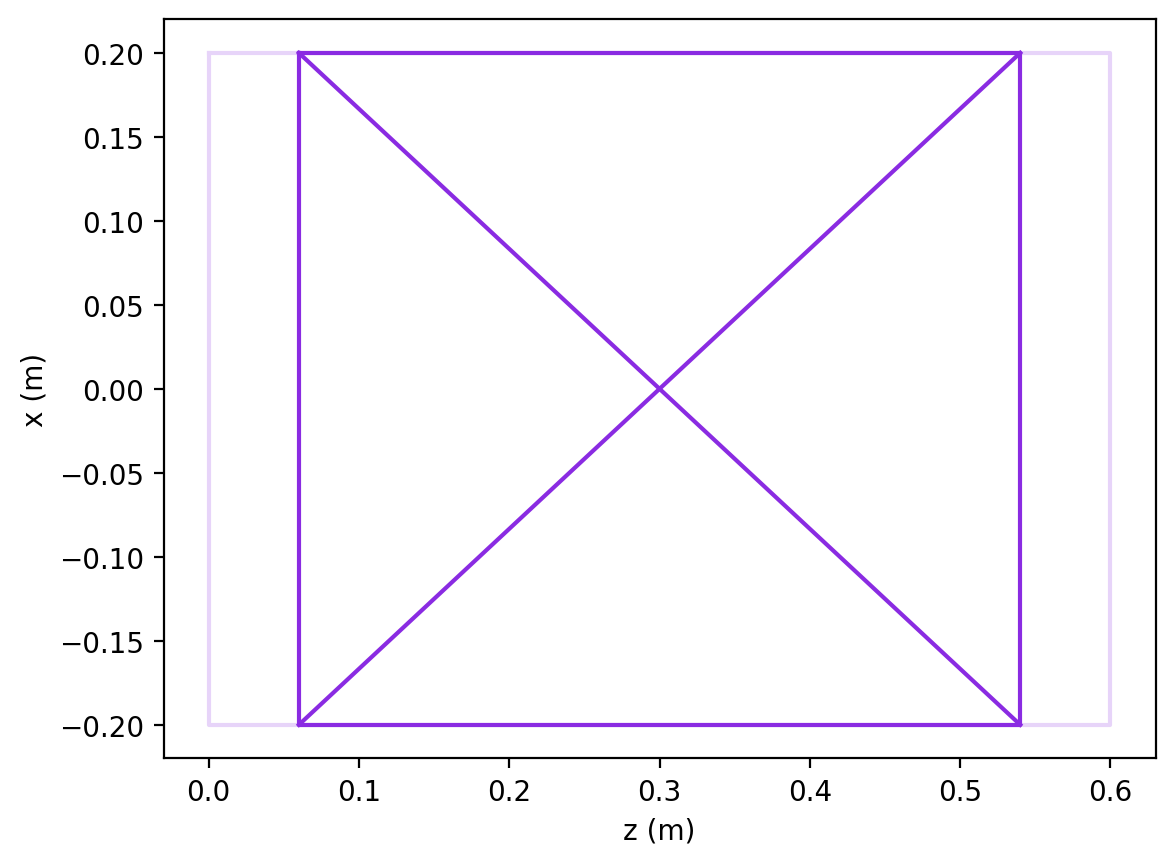

Type:        Map1D_B
String form:
Name: sol
Type: Map1D_B
s-entrance: 0 m.
s-exit: 0.6 m.
Length: 0.6
Width: 0.4 m.
File:        ~/GitHub/lume-gpt/gpt/maps.py
Docstring:   Defines a 1D [z, Bz] cylindrically symmetric magnetic field map object

In [2]:
from gpt.maps import Map1D_B
from gpt.lattice import Lattice

sol = Map1D_B('sol', 'fields/solenoid_SLA_L60_1D.gdf')
?sol

sol.place()
sol.plot_floor()

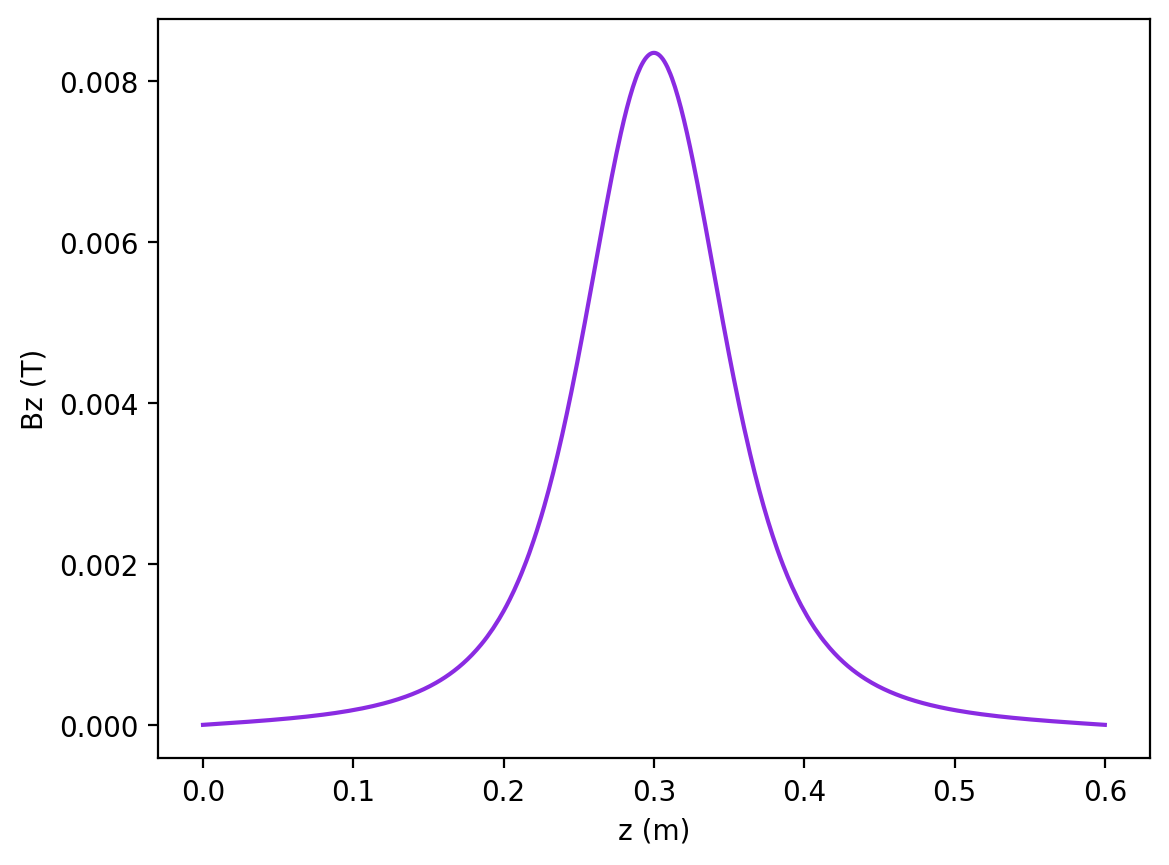

In [3]:
sol.plot_field_profile()

In [4]:
for line in sol.gpt_lines(): 
    print(line)

sol_x = 0.0;
sol_y = 0.0;
sol_z = 0.3;
sol_yaw = 0;
sol_pitch = 0;
sol_roll = 0;
sol_scale = 1;
Map1D_B("wcs", "GxyzXYZ", sol_x, sol_y, sol_z, sol_yaw, sol_pitch, sol_roll, "/Users/colwyngulliford/GitHub/lume-gpt/examples/elements/fields/solenoid_SLA_L60_1D.gdf", "z", "Bz", sol_scale);


In [5]:
?sol.field_integral
sol.field_integral

np.float64(0.0010917178030000001)

Type:        property
String form: <property object at 0x12fe948b0>
Docstring:   Returns the on axis integral of the Fz 

In [6]:
?sol.larmor_angle
print('Larmor Angle:', sol.larmor_angle(p=1e6)*180/np.pi,' deg.')

Larmor Angle: -9.376132418274313  deg.


Signature: sol.larmor_angle(p=1000000.0)
Docstring: <no docstring>
File:      ~/GitHub/lume-gpt/gpt/maps.py
Type:      method

## With Lattice Generation

In [7]:
from gpt.lattice import Lattice

In [8]:
lat = Lattice('Map1D_B')
lat.add(Map1D_B('sol', 'fields/solenoid_SLA_L60_1D.gdf', scale=0.01), ds = 0.5, element_origin='center')  

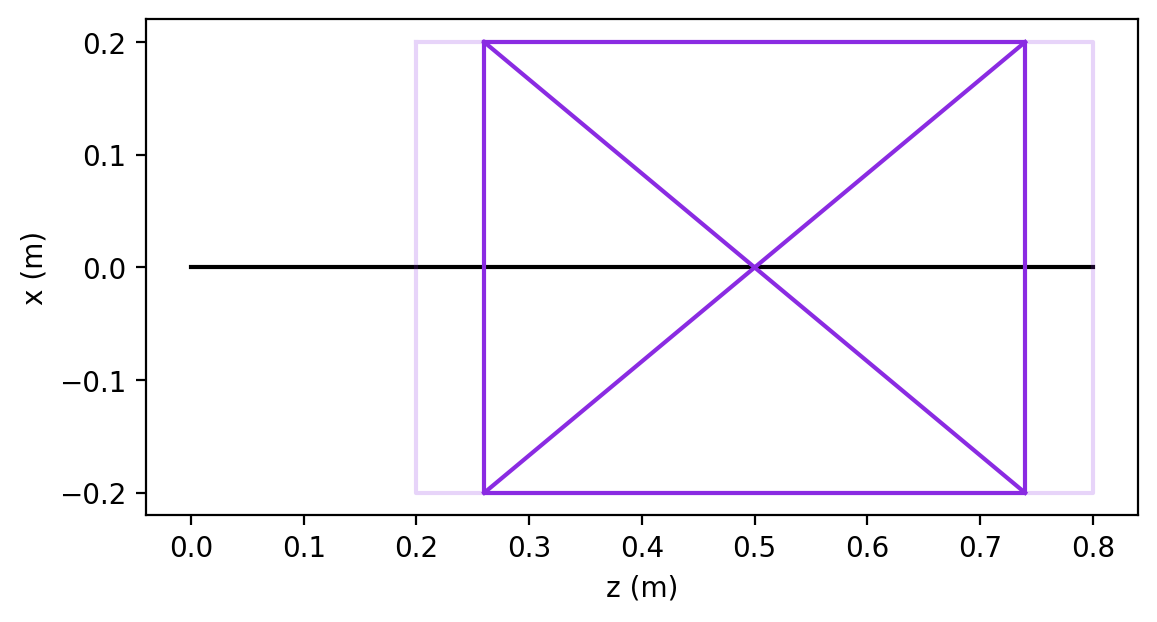

In [9]:
lat.plot_floor()
lat.write_gpt_lines(output_file='gpt.temp.in');

In [10]:
from distgen import Generator

E = 1e6
pz = np.sqrt(E**2 - MC2**2)

DISTGEN_YAML=f"""
n_particle: 1000
random_type: hammersley
species: electron

total_charge:
  units: nC
  value: 1
start:
  type: time
r_dist:
  sigma_xy:
    units: mm
    value: 1
  alpha:
    units: dimensionless
    value: 0.0
  type: rsg
transforms:
  avgpz:
    type: set_avg pz
    avg_pz: {pz} eV/c
"""

In [11]:
D = Generator(DISTGEN_YAML)
P = D.run()

In [12]:
G = GPT('gpt.temp.in', initial_particles=P)
G.set_variables({'ZSTOP': 1, 'Ntout': 500, 'sol_scale': 2})
G.run()

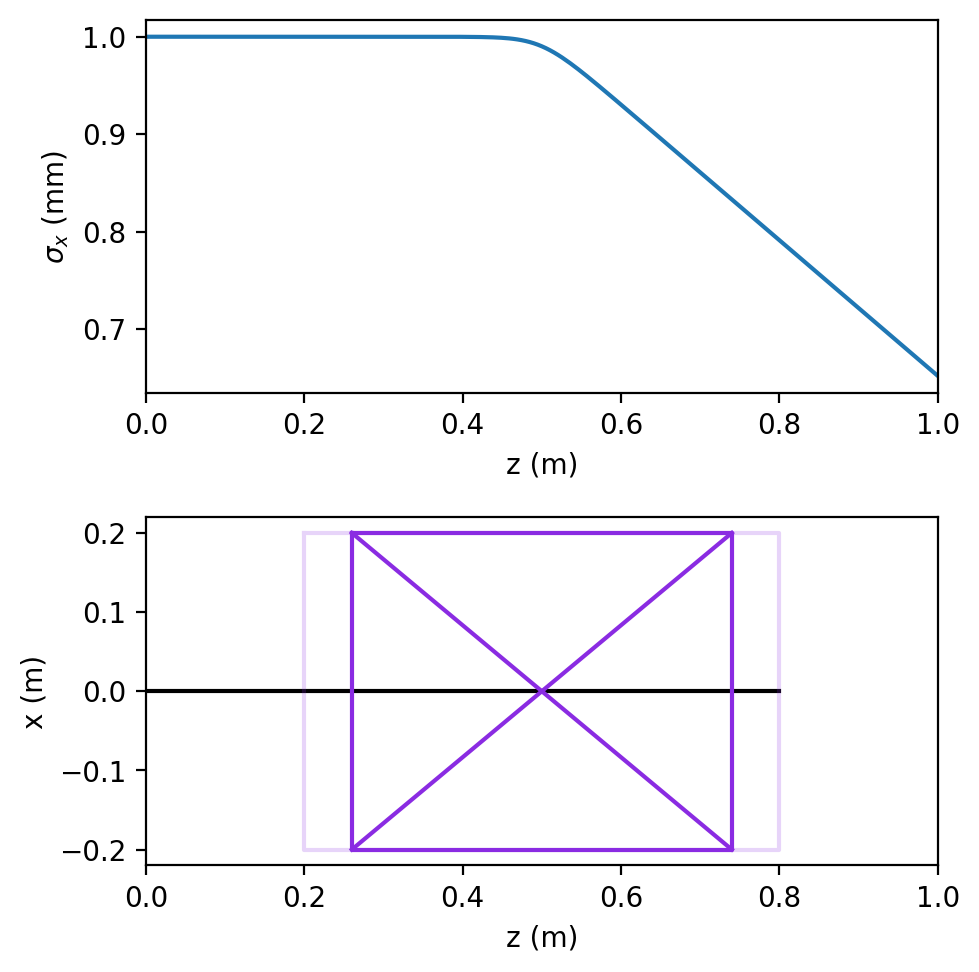

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(5, 5))

axs[0].plot(G.tout_stat('mean_z'), G.tout_stat('sigma_x')*1e3)
axs[0].set_xlabel('z (m)')
axs[0].set_ylabel(r'$\sigma_x$ (mm)')

G.lattice.plot_floor(ax = axs[1])

axs[0].set_xlim([0, 1])
axs[1].set_xlim([0, 1])

plt.tight_layout()


In [15]:
def check_parsing():
    
    lat1 = Lattice('Map1D_B')
    lat1.add(Map1D_B('sol1', 'fields/solenoid_SLA_L60_1D.gdf', scale=0.01), ds = 0.5, element_origin='center')  
    lat1.write_gpt_lines(output_file='parse_test.temp.in');

    G = GPT('parse_test.temp.in')
    lat2 = G.lattice

    os.remove('parse_test.temp.in')
    
    # Basic info
    assert lat1['sol1']._length==lat2['sol1']._length
    assert lat1['sol1']._width==lat2['sol1']._width
    assert lat1['sol1']._height==lat2['sol1']._height
    # assert lat1['sol1']._ecs==lat2['sol1']._ecs # FIX LATER
    assert lat1['sol1'].name == lat2['sol1'].name
    assert lat1['sol1']._scale == lat2['sol1']._scale
    
check_parsing()
